# Coursework 2: Data Processing

## Task 1
This coursework will assess your understanding of using NoSQL to store and retrieve data.  You will perform operations on data from a collection of scientific articles in a MongoDB database.  You will be required to run code to answer the given questions in the Jupyter notebook provided.

Download the dataset and import into a collection called 'articles' in a database called 'dblp'.  You do not need to set up any authentication.  Answer the following questions in the provided cells.

Answers should be efficient in terms of speed.  Answers which are less efficient will not get full marks.

In [1]:
%%bash
#Mongoimport of the JSON data.
mongoimport --db dblp --collection articles --file articles.json

2020-12-09T18:33:16.242+0000	connected to: mongodb://localhost/
2020-12-09T18:33:19.246+0000	[........................] dblp.articles	25.5MB/1.13GB (2.2%)
2020-12-09T18:33:22.243+0000	[#.......................] dblp.articles	50.6MB/1.13GB (4.4%)
2020-12-09T18:33:25.242+0000	[#.......................] dblp.articles	75.1MB/1.13GB (6.5%)
2020-12-09T18:33:28.250+0000	[##......................] dblp.articles	99.6MB/1.13GB (8.6%)
2020-12-09T18:33:31.249+0000	[##......................] dblp.articles	125MB/1.13GB (10.8%)
2020-12-09T18:33:34.244+0000	[###.....................] dblp.articles	149MB/1.13GB (12.9%)
2020-12-09T18:33:37.242+0000	[###.....................] dblp.articles	174MB/1.13GB (15.0%)
2020-12-09T18:33:40.250+0000	[####....................] dblp.articles	197MB/1.13GB (17.0%)
2020-12-09T18:33:43.243+0000	[####....................] dblp.articles	220MB/1.13GB (19.0%)
2020-12-09T18:33:46.250+0000	[#####...................] dblp.articles	245MB/1.13GB (21.1%)
2020-12-09T18:33:49.242+00

 ## Context
    
Bibliometrics Ltd. has hired you, dear data scientist, to analyse the latest articles in Computer Science collected by the DBLP (https://dblp.uni-trier.de/) open bibliographic service and further processed by the AMiner team (https://www.aminer.cn/citation). You have been provided with the articles from 2017 and 2019 and an MS Teams chat window with "The Management", on which you will get the questions you need to answer. 

In [1]:
#import section
from networkx import Graph, connected_components, ego_graph
from pymongo import MongoClient

### 1) 

Before the first question pops in the chat window, you better off set up everything to provide answers.

Task:

Off the Jupyter notebook, create a 'dblp' database and load the articles dataset into a collection named 'articles'.

Write a function that given the name of a database and the name of a collection returns a pymongo collection object of the collection using the user you just created. Use this function to create a pymongo collection object of the 'articles' collection.


[5 points]

In [2]:
def get_collection(dbname, collection_name):
    """
    Connects to the server, and returns a collection object
    of the `dbname` collection in the `dblp` database
    """
    connection = MongoClient("localhost")
    return connection[dbname][collection_name]

In [3]:
# the collection on which you will work on
articles = get_collection('dblp','articles')
authors = get_collection('dblp','authors')

In [11]:
articles.create_index([("references", 1), ("page_start", 1), ("page_end", 1)])
articles.count_documents({})

955181

### 1) 

The Management has logged in... they want to know how many articles of each type according to the 'doc_type' property are in the dataset. However, being the competent data scientist you are, you know that you always need to verify your data before start spitting out charts...

### Task:

Write a function that returns the number of articles missing the 'doc_type' property or having it equal to the empty string ("") 

[5 points] 



In [12]:
def count_missing_doc_types(articles):
    """
    :param articles A PyMongo collection of articles
    :return: int: Number or articles without a a 'doc_type' property or having
    it equal to the empty string ('')
    """
    return articles.count_documents(
        {"$or": [{"doc_type": {"$exists": False}}, {"doc_type": ""}]}
    )

In [13]:
print(count_missing_doc_types(articles))

0


### 2) 

You inform The Management of how many articles are missing the doc_type property or have it empty. They would like to fix as many as possible before moving forward. They may be able to infer the missing types based on the article publisher, so they ask: what are the publishers of the articles that are missing the doc_type property?

### Task:

Write a function that returns the set of publishers of articles that are missing the doc_type property or have it equal to the empty string. 

[5 points]

In [14]:
def get_publishers_of_articles_missing_type(articles):
    """
    :param articles PyMongo collection of articles
    :return: Set: set of publishers of articles that are missing the doc_type
    property, defined as not having the field at all, or having it equal to the
    empty string.
    """
    return articles.distinct(
        "publisher", {
            "$or": [{"doc_type": {"$exists": False}}, {"doc_type": ""}]
        }
    )

In [15]:
print(len(get_publishers_of_articles_missing_type(articles)))

0


### 3)

The Management analysed the set you provided in the previous task and decided that:

 1) Articles missing doc_type  with publisher == 'Springer, Cham' should have 'doc_type' == 'Book'
 
 2) Articles missing doc_type with publisher  == 'RFC Editor' should have 'doc_type' == 'RFC'
 
 3) The remainder of articles missing doc_type should have 'doc_type' == 'N/A'
 
Task:

Write a function that updates the article collection according to The Management's decision.

[5 points]

In [16]:
# The goal of this one is to make them update. Part of the data cleaning process.
# Full mark should have one single pass update many. I think there are enough Springer, Cham elements 
#to notice when they are doing something wrong.

def update_doc_types(articles):
    """
    :param articles: PyMongo collection of articles
    :return: PyMongo UpdateResult object
    """
    bulk_operation = articles.initialize_unordered_bulk_op()

    bulk_operation.find(
        {
            "publisher": "Springer, Cham",
            "$or": [{"doc_type": {"$exists": False}}, {"doc_type": ""}],
        }
    ).update({"$set": {"doc_type": "Book"}})

    bulk_operation.find(
        {
            "publisher": "RFC Editor",
            "$or": [{"doc_type": {"$exists": False}}, {"doc_type": ""}],
        }
    ).update({"$set": {"doc_type": "RFC"}})

    bulk_operation.find(
        {"$or": [{"doc_type": {"$exists": False}}, {"doc_type": ""}]}
    ).update({"$set": {"doc_type": "N/A"}})

    return bulk_operation.execute()

In [17]:
print(update_doc_types(articles))

<ipython-input-16-cac4d47c087a>:10: DeprecationWarning: initialize_unordered_bulk_op is deprecated
  bulk_operation = articles.initialize_unordered_bulk_op()


{'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 0, 'nModified': 0, 'nRemoved': 0, 'upserted': []}


### 4)

You are finally ready to answer the original question: What is the distribution of document types in the dataset?

Task:

Write a function that returns a dictionary with doc_types as keys and the number of articles of each type as values.

e.g:

{'Conference' : 4566 , 'N/A' : 7992 ...}



[5 points]


In [18]:
def get_types_distribution(articles):
    """
    :param articles: PyMongo collection of articles
    :return: Dictionary with article types as keys, and number of articles of
    type as value
    """
    cursor = articles.aggregate(
        [{"$group": {"_id": "$doc_type", "count": {"$sum": 1}}}]
    )

    result = {}
    for rec in cursor:
        result[rec["_id"]] = rec["count"]

    return result

In [19]:
print(get_types_distribution(articles))

{'Patent': 112, 'RFC': 289, 'N/A': 74167, 'Book': 17998, 'Dataset': 3, 'Journal': 385450, 'BookChapter': 103, 'Repository': 87683, 'Conference': 389376}


###  5)

Do longer articles (in number of pages) have more references?

Task:

Return an histogram dictionary with the following specification:

{
"1-5" : Average references of articles between 1 and 5 pages inclusive

"6-10" : Average references of articles between 6 and 10 pages inclusive

"11-15" : Average references of articles between 11 and 15 pages inclusive

"16-20" : Average references of articles between 16 and 20 pages inclusive

"21-25" : Average references of articles between 21 and 25 pages inclusive

"25-30" : Average references of articles between 25 and 30 pages inclusive

">30" : Average references of articles with more than 30 pages
}

A fellow data scientist of your team has found that some articles have no 'references' field, while others have unusually large page numbers. The Management decides that for this task you should

* Ignore articles that are missing the 'references' field
* Ignore articles with page numbers greater than 6 digits
* Ignore articles with page numbers that cannot be parsed to integers (e.g. 900467-12)



You may use pandas to help you with statistical calculations, but do consider the efficiency of your solution.


Clarifications:

* Articles that start and end at the same page have 1 page, not zero!


[8 points]


In [20]:
def length_vs_references(articles):
    """
    :param collection A PyMongo collection object
    :return Histogram as a dictionary in the form described above
    """

    match_1_stage = {
        "$match": {
            "references": {"$exists": True, "$ne": []},
            "page_start": {"$exists": True, "$ne": ""},
            "page_end": {"$exists": True, "$ne": ""},
        }
    }

    page_conversion_stage = {
        "$addFields": {
            "convertedPageStart": {
                "$convert": {
                    "input": "$page_start",
                    "to": "long",
                    "onError": -1,
                    "onNull": -1,
                }
            },
            "convertedPageEnd": {
                "$convert": {
                    "input": "$page_end",
                    "to": "long",
                    "onError": -1,
                    "onNull": -1,
                }
            },
            "reference_size": {"$size": "$references"},
        }
    }

    match_2_stage = {
        "$match": {
            "$and": [
                {"convertedPageStart": {"$ne": -1}},
                {"convertedPageEnd": {"$ne": -1}},
            ]
        }
    }

    project_stage = {
        "$project": {
            "convertedPageStart": 1,
            "convertedPageEnd": 1,
            "references": 1,
            "no_of_pages": {
                "$add": [{
                    "$subtract": ["$convertedPageEnd", "$convertedPageStart"]
                }, 1]
            },
        }
    }

    match_3_stage = {
        "$match": {
            "$and": [
                {"no_of_pages": {"$lt": 100000}},
                {"no_of_pages": {"$gte": 0}},
            ]
        }
    }

    group_stage = {
        "$bucket": {
            "groupBy": "$no_of_pages",
            "boundaries": [1, 6, 11, 16, 21, 26, 31],
            "default": 31,
            "output": {"Avg references": {"$avg": {"$size": "$references"}}},
        }
    }
    res_set = articles.aggregate(
        [
            match_1_stage,
            page_conversion_stage,
            match_2_stage,
            project_stage,
            match_3_stage,
            group_stage,
        ]
    )
    res_set = list(res_set)

    hist_dict = {}

    for res in res_set[0:-1]:
        start = res["_id"]
        end = start + 5 - 1
        hist_dict["{}-{}".format(start, end)] = res["Avg references"]

    hist_dict[">30"] = res_set[-1]["Avg references"]

    return hist_dict

In [21]:
print(length_vs_references(articles))

{'1-5': 7.80959911361805, '6-10': 12.943604728505438, '11-15': 19.26696415044967, '16-20': 21.93083583252851, '21-25': 23.84250175192712, '26-30': 26.984712799638174, '>30': 32.62567744346851}


###  6)

Being the competent data scientist you are, you remember that before sending the results to The Management you  should be verify that they are meaningful and not affected by data quality. Can you trust these averages are not affected by outliers?

Task:

Extend or modify the previous function to return for each article length range the following dictionary:

{"1-5" : {'outliers'  
             {
          
            id: article_id, 
          
            num_citations: number of citations, 
          
             z-score: z-score
          }, 
 "6-10" : {'outliers'  
             {
          
            id: article_id, 
          
            num_citations: number of citations, 
          
             z-score: z-score
          } ,
   .... and so on.....
 }

for articles with a number of citations with a z-score  greater or equal than 3 ((https://www.statisticshowto.com/probability-and-statistics/z-score/))

Note that we say "for each article length range", therefore, z-score needs to be computed using the mean and stdev of each sample of the provided article lengths.

You may use pandas to help you with statistical calculations, but do consider the efficiency of your solution.

  


[8 points]


In [154]:
def get_reference_outliers(articles):
    """
    :param articles A PyMongo collection object
    :return Dictionary of the form described above
    """
    
    match_1_stage = {"$match":
               {"$and":
                [
                    {"page_start":{"$ne":""}},
                    {"page_end":{"$ne":""}},
                    {"page_start":{ "$not":{"$regex":"-"}}},
                    {"page_end":{ "$not":{"$regex":"-"}}},
                    {"page_start":{"$exists": True},"$expr":{"$lte":[{"$strLenCP":"$page_start"},6]}},
                    {"page_end":{"$exists": True}},
                    {"references":{"$exists": True, "$ne": []}}
                ]
               }
              }
    
    page_conversion_stage = {
        "$addFields": {
            "convertedPageStart": {
                "$convert": {
                    "input": "$page_start",
                    "to": "long",
                    "onError": -1,
                    "onNull": -1,
                }
            },
            "convertedPageEnd": {
                "$convert": {
                    "input": "$page_end",
                    "to": "long",
                    "onError": -1,
                    "onNull": -1,
                }
            },
            "reference_size": {"$size": "$references"},
        }
    }

    match_2_stage = {
        "$match": {
            "$and": [
                {"convertedPageStart": {"$ne": -1}},
                {"convertedPageEnd": {"$ne": -1}},
            ]
        }
    }
    
    project_stage = {
        "$project": {
            "convertedPageStart": 1,
            "convertedPageEnd": 1,
            "reference_size":1,
            "id": 1,
            "no_of_pages": {
                "$add": [{
                    "$subtract": ["$convertedPageEnd", "$convertedPageStart"]
                }, 1]
            },
        }
    }
    
    bucket_stage = {
        "$bucket":{
            "groupBy":"$no_of_pages",
            "boundaries":[1,6,11,16,21,26,31],
            "default" : ">30",
            "output":{
                "no_of_articles":{"$sum":1}, 
                "average_references":{"$avg":"$reference_size"},
                "standarddev":{"$stdDevPop":"$reference_size"},
                "outlier": { "$push": {"id":"$id", "num_citations":"$reference_size", "no_of_pages":"$no_of_pages"}}
            }
        }
    };
    
    unwind_stage = {"$unwind": "$outlier"}
    
    z_score_stage_1 = {"$addFields": {
        "outlier.z-score": {
            "$subtract": ["$outlier.num_citations", "$average_references"]},
    }}
    
    z_score_stage_2 = {"$set": {"outlier.z-score": {"$divide": ["$outlier.z-score", "$standarddev"]}}}
    
    z_score_filter_stage = {"$match": {"outlier.z-score": {"$gte": 3}}}
    
    project_z_score_stage = {"$project": {'_id': 0, "outlier": 1, "z-score": 1}}
    
    bucket_final_stage = {"$bucket": {
            "groupBy": "$outlier.no_of_pages",
            "boundaries": [1, 6, 11, 16, 21, 26, 31],
            "default": ">30",
            "output": {"outlier": {"$push": "$outlier"}

                       }
    }}
    
    res_set = articles.aggregate(
        [
            match_1_stage,
            page_conversion_stage,
            match_2_stage,
            project_stage,
            bucket_stage,
            unwind_stage,
            z_score_stage_1,
            z_score_stage_2,
            z_score_filter_stage,
            project_z_score_stage,
            bucket_final_stage
        ],
        allowDiskUse=True
    )
    
    return_dict = {}
    
    l = []
    
    for res in res_set:
        l.append(res)
    
    for res in l[0:-1]:
        
        start = int(res['_id'])
        end = start + 4
        key = "{}-{}".format(str(start), str(end))
        
        return_dict[key] = {'outliers':res['outlier']}
    
    return_dict[l[-1]['_id']] = {'outliers':l[-1]['outlier']}
    
    return return_dict

In [155]:
res_set = get_reference_outliers(articles)

In [158]:
res_set['>30']

{'outliers': [{'id': 2793622148,
   'num_citations': 171,
   'no_of_pages': 33,
   'z-score': 3.929057830064616},
  {'id': 2973419442,
   'num_citations': 347,
   'no_of_pages': 40,
   'z-score': 8.92638488863329},
  {'id': 2899090608,
   'num_citations': 242,
   'no_of_pages': 36,
   'z-score': 5.9450249957372066},
  {'id': 2604799547,
   'num_citations': 397,
   'no_of_pages': 106,
   'z-score': 10.346080075726663},
  {'id': 2758508599,
   'num_citations': 177,
   'no_of_pages': 84,
   'z-score': 4.099421252515821},
  {'id': 2883445328,
   'num_citations': 300,
   'no_of_pages': 78,
   'z-score': 7.591871412765519},
  {'id': 2795981059,
   'num_citations': 173,
   'no_of_pages': 57,
   'z-score': 3.985845637548351},
  {'id': 2535481428,
   'num_citations': 169,
   'no_of_pages': 41,
   'z-score': 3.872270022580881},
  {'id': 2803704088,
   'num_citations': 158,
   'no_of_pages': 42,
   'z-score': 3.559937081420339},
  {'id': 2970434686,
   'num_citations': 388,
   'no_of_pages': 43,


limit_output extension: Maximum message size of 10000 exceeded with 24050 characters

### 7) 

What are the co-authors of an author? 

Task:

Write a function that receives as parameter an author id and returns the id, names and affiliations (if present) of all co-authors.

[8 points]

Clarification:

* Assume authors are uniquely identified by their ids.


In [25]:
def get_collaborators(articles, author_id):
    """
    Input: articles: PyMongo collection of articles
        author_id : id of author
    Output: List of collaborator documents {id, [{name,affiliation}]}
    """
    co_authors = []
    collaborator_id_set = set()

    documents = articles.find({"authors.id": author_id})

    for document in documents:
        article_authors = document["authors"]
        for author in article_authors:
            collaborator_id_set.add(author["id"])

    collaborator_id_set.remove(author_id)

    for collaborator_id in collaborator_id_set:

        author_hash = set()

        collaborator_dict = {}
        collaborator_dict["id"] = collaborator_id

        names = []

        documents = articles.find({"authors.id": collaborator_id},
                                  {"authors": 1})

        for document in documents:
            author_list = document["authors"]
            for author in author_list:
                if author["id"] == collaborator_id:
                    temp_dict = {}
                    temp_dict["name"] = author["name"]
                    if "org" in author:
                        temp_dict["affiliation"] = author["org"]
                    temp_hash = hash(frozenset(temp_dict.items()))
                    if temp_hash not in author_hash:
                        author_hash.add(temp_hash)
                        names.append(temp_dict)

        collaborator_dict["names"] = names
        co_authors.append(collaborator_dict)

    return co_authors

In [26]:
l = get_collaborators(articles, 53423)

In [27]:
for a in l:
    print(a)
    print('\n')

{'id': 2122359715, 'names': [{'name': 'Will Rosenbaum'}, {'name': 'Will Rosenbaum', 'affiliation': 'Algorithms and Complexity, MPI for Informatics, Max Planck Society'}, {'name': 'Will Rosenbaum', 'affiliation': 'Tel‐Aviv University ,'}, {'name': 'Will Rosenbaum', 'affiliation': 'Max-Planck-Institute for Informatics, , Germany'}]}


{'id': 2078633956, 'names': [{'name': 'Yishay Mansour', 'affiliation': 'Tel-Aviv University and Microsoft Research, Tel-Aviv , Israel'}, {'name': 'Yishay Mansour'}, {'name': 'Yishay Mansour', 'affiliation': 'Tel Aviv University and Microsoft Research#TAB#'}, {'name': 'Yishay Mansour', 'affiliation': 'Tel Aviv University Tel Aviv, Israel'}, {'name': 'Yishay Mansour', 'affiliation': 'Tel‐Aviv University ,'}, {'name': 'Yishay Mansour', 'affiliation': 'Tel-Aviv University & Google Research, Tel-Aviv, Israel'}, {'name': 'Yishay Mansour', 'affiliation': 'Google Inc.,#TAB#'}, {'name': 'Yishay Mansour', 'affiliation': 'Google and Tel Aviv University'}, {'name': 'Yi

limit_output extension: Maximum message size of 10000 exceeded with 12019 characters

### 8)

The Management anticipates that several queries based on authors and their connections will be required in the near future. You have been asked to take the necessary steps to ensure these queries are easier to express and faster to perform.

Task : Create a collection named authors containing for each author a document like the one below:
{
_id: author's id
name_affiliations: array of  {name: name, affiliation: affiliation} associated to author's id
articles: array of article ids authored by this author id
co-authors : Array of ids of co-authors
}

Hint: You may need to create an index to speed up this one. If you do, do it programatically as part of your function. 

Hint 2: We provide an authors.json with a sample of the expected output.

[12 points]

In [57]:
def create_authors_collection(articles):
    """
    :param: articles collection
    : output: Pymongo cursor of the newly created authors collection
    """
    
    project_1 = {"$project": {"_id": 0,"authors": 1,"id": 1}}
    
    add_field = {"$addFields": {"collated_authors_ids": "$authors.id"}}
    
    unwind_authors = {"$unwind": "$authors"}
    
    group_author_ids = {"$group":{
                        '_id': "$authors.id",
                        
                        "articles":
                        {
                            "$push": "$id"
                        },

                        "coauthors_ids":
                        {
                            "$push": "$collated_authors_ids"
                        },
                        
                        "names": 
                        {
                            "$addToSet": 
                            {
                                "name": "$authors.name",
                                "affiliation": "$authors.org"
                            }
                        }
    }}
    
    set_new_id = {"$set": {"new_id": ["$_id"]}}
    
    project_difference = {"$project": {
                                        "_id": 1,
                                        "articles": 1,
                                        "names": 1,
                                        "coauthors": 
                                                    {"$setDifference": [
                                                        {"$reduce": 
                                                          {
                                                              "input": "$coauthors_ids", 
                                                              'initialValue': [], 
                                                              'in': {'$setUnion': ["$$value", "$$this"]}
                                                          }
                                                        }, 
                                                        "$new_id"]}
    }}
    
    output = {"$out": "authors"}
    
    return articles.aggregate([project_1, 
                               add_field, 
                               unwind_authors, 
                               group_author_ids, 
                               set_new_id,
                               project_difference,
                               output], 
                              allowDiskUse=True)

In [58]:
cur = create_authors_collection(articles)

### 9)


The Management is investigating the ties of authors with different countries. They would like to know how many connections they have with colleagues from other countries, even if they are indirect.

Task:

Given an author id and the name of a country, return the ids of the authors in the network of co-authors of radius 3 (that is, three degrees of separation) that have an affiliation in that country.

You may use the networkx package to help you with graph related computations. However, do consider the efficiency of the solution.



[10 points]

Clarification:

* For this exercise, ignore authors without affiliation, or affiliations that do not explicitly include the name of the country. Consider them to not match the query.

* The figure below provides an example input and output

* What if I'm stuck with question 8)? You can use the sample provided for question 8 for development of questions 9) and 10).
We will mark questions 9) and 10) by running them on the actual answer. Do note the actual answer is much larger than the sample, take this in consideration when designing your solution.

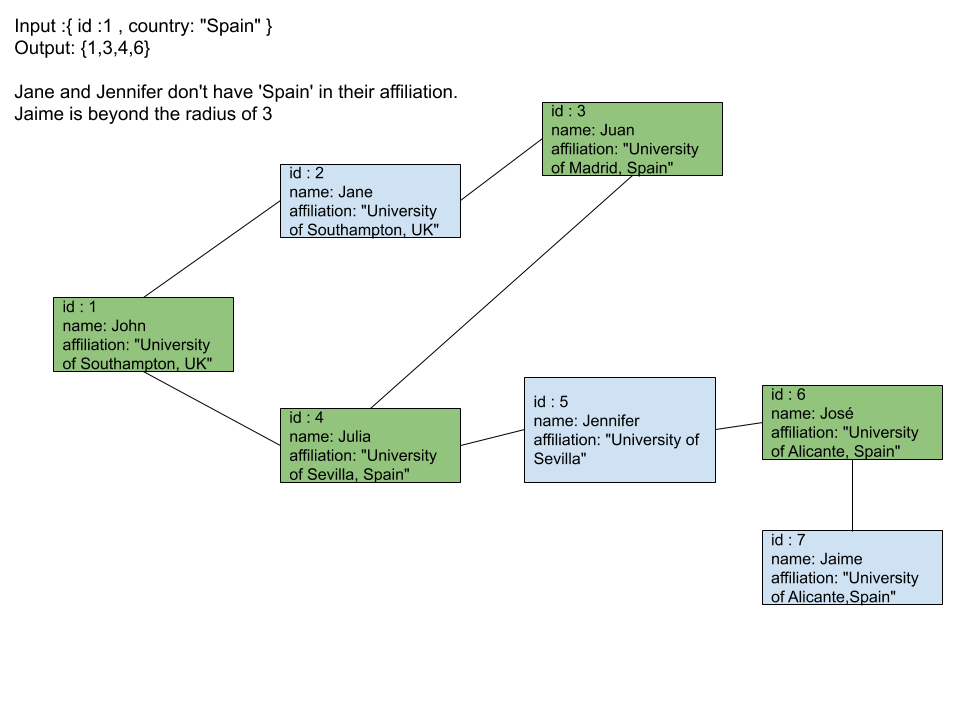

In [2]:
def get_network(authors, author_id, country):
    """
    Input: Authors collection, author_id, String country
    Output: List of ids of authors at three or less hops of distance with an
    affiliation that includes 'country'
    """
    is_visited = set()
    stack = []

    graph = Graph()
    is_visited.add(author_id)
    graph.add_node(author_id, country_match=True)

    cur = authors.find({"_id": author_id}, {"coauthors": 1})
    for row in cur:
        author_details = row
    if "coauthors" in author_details:
        if author_details["coauthors"] != []:
            for author in author_details["coauthors"]:
                stack.append((author_id, author))

    while stack:
        pair = stack.pop()
        parent = pair[0]
        child = pair[1]

        cur = authors.find(
            {"_id": child},
            {"names.affiliation": {"$regex": "*" + country + "*",
                                   "$options": "i"}},
        )
        graph.add_edge(parent, child)

        if cur:
            graph.nodes[child]["country_match"] = True
        else:
            graph.nodes[child]["country_match"] = False

        is_visited.add(child)

        cur = authors.find({"_id": child}, {"coauthors": 1})

        for row in cur:
            if row["_id"] not in is_visited:
                stack.append((child, row["_id"]))

    graph = ego_graph(graph, author_id, radius=3)
    all_connected_nodes = list(graph.nodes())
    return_list = []
    for node in all_connected_nodes:
        if graph.nodes[node]["country_match"]:
            return_list.append(node)
    return return_list

In [6]:
graph = get_network(authors, 44880, 'Spain')

In [7]:
print(graph)

[44880, 2571834967, 2990662754, 2004887157, 225525199, 2311229737, 2040998117, 2013569670, 2694302404, 2990723644, 2989421000, 2629959355, 2190717548, 2915837130, 2911540316, 2980340419, 2164966972, 2171487651, 1844400128, 2798562566, 2099554632, 2612665046, 207769766, 1860074921, 2963326360, 714308370, 2138229758, 2593705452, 2591957861]


### 10)

The Management wants to analyse the community of authors that publish data science and their co-authors. In particular, how connected it is? 

Task:

Produce the subgraph of authors that has published one or more 'Data science' articles and their co-authors and report the number of connected components and the size of the largest and smallest connected components.

You may use the networkx package to help you with graph related computations. However, do consider the efficiency of the solution.

[10 points]



In [31]:
def data_science_community(articles, authors):
    """
    Input: Articles and authors collections. You may use only one of them
    Output: 3-tuple reporting on subgraph of authors of data science articles
    and their co-authors: (number of connected components,size of largest
    connected component, size of smallest connected component)
    """
    graph = Graph()

    match_1_stage = {"$match": {"fos.name": "Data science"}}

    project_stage = {"$project": {"authors.id": 1}}

    unwind_stage = {"$unwind": "$authors"}

    res_set = list(articles.aggregate([match_1_stage, project_stage,
                                       unwind_stage]))

    data_science_authors = set()
    for res in res_set:
        data_science_authors.add(res["authors"]["id"])
        graph.add_node(res["authors"]["id"])

    for author in data_science_authors:
        author_records = authors.find({"_id": author})
        for author_record in author_records:
            co_authors = author_record["coauthors"]
            for co_author in co_authors:
                graph.add_edge(author, co_author)

    connected_items = connected_components(graph)
    connected_graph = sorted(connected_items, key=len, reverse=True)

    largest = len(list(graph.subgraph(connected_graph[0]).nodes()))
    smallest = len(list(graph.subgraph(connected_graph[-1]).nodes()))

    connected_items = connected_components(graph)
    no_connected_components = len(list(connected_items))

    return no_connected_components, largest, smallest

In [32]:
res = data_science_community(articles, authors)

In [33]:
res

(43500, 6992, 1)

## Task 2
This task will assess your ability to use the Hadoop Streaming API and MapReduce to process data. For each of the questions below, you are expected to write two python scripts, one for the Map phase and one for the Reduce phase. You are also expected to provide the correct parameters to the `hadoop` command to run the MapReduce process. Write down your answers in the specified cells below.

You will use the same dataset of articles that you used for task 1.

To help you, `%%writefile` has been added to the top of the cells, automatically writing them to "mapper.py" and "reducer.py" respectively when the cells are run.

### 1) 

Answer Question 2) of task 1 using the MapReduce paradigm (repeated below for your convenience)

Return the set of publishers of articles that are missing the doc_type property or have it equal to the empty string. 

[8 points]

In [ ]:
%%writefile mapper.py
#!/usr/bin/env python
#Answer for mapper.py

import sys
lines = sys.stdin.readlines()

for line in lines:
    if line.find('"publisher"') != -1 and (line.find("doc_type") == -1 or line.find('"doc_type":""') != -1):
        token = line.split('"publisher":"')[1].split('",')[0]
        if token != '':
            print(token + "\t1")


In [ ]:
%%writefile reducer.py
#!/usr/bin/env python
#Answer for reducer.py

import sys
from collections import defaultdict

input_pairs = sys.stdin.readlines()

accumulator = defaultdict(lambda: 0)

for row in input_pairs:
    # Split the line into our key value pair.
    key_value_pair = row.split("\t", 1)
    
    # If we don't have a pair, ignore the line, as something has gone wrong.
    if len(key_value_pair) != 2:
        continue
        
    word = key_value_pair[0]
    # Strip removes whitespace at the start and end of a string. In this case, making sure we have just a number.
    # We also convert it to an integer here.
    count = int(key_value_pair[1].strip())
    
    # Retrieve the count of that word we've seen so far, add to it, then store the result.
    accumulator[word] = accumulator[word] + count
    
for (key, value) in accumulator.items():
    #print(key + "\t" + str(value))
    print('name-' + key)

In [ ]:
%%bash
#Hadoop command to run the map reduce.

rm -rf output

hadoop-standalone-mode.sh

hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
-files mapper.py,reducer.py \
-input articles.json \
-mapper ./mapper.py \
-reducer ./reducer.py \
-output output

### 2) 
Answer Question 5) of task 1 using the MapReduce paradigm (repeated below for your convenience)

Do longer articles (in number of pages) have more references?

Task:

Return an histogram dictionary with the following specification:

{
"1-5" : Average references of articles between 1 and 5 pages inclusive

"6-10" : Average references of articles between 6 and 10 pages inclusive

"11-15" : Average references of articles between 11 and 15 pages inclusive

"16-20" : Average references of articles between 16 and 20 pages inclusive

"21-25" : Average references of articles between 21 and 25 pages inclusive

"25-30" : Average references of articles between 25 and 30 pages inclusive

">30" : Average references of articles with more than 30 pages
}

A fellow data scientist of your team has found that some articles have no 'references' field, while others have unusually large page numbers. The Management decides that for this task you should

* Ignore articles that do not have references
* Ignore articles with page numbers greater than 6 digits


Clarifications:
*) Articles that start and end at the same page have 1 page, not zero!


[12 points]

In [13]:
%%writefile mapper2.py
#!/usr/bin/env python
#Answer for mapper.py

import sys
lines = sys.stdin.readlines()

for line in lines:
    if line.find('page_start')!= -1 and line.find('page_end')!= -1 and line.find('references')!= -1:
        try:
            page_start = int(line.split('"page_start":"')[1].split('",')[0])
            page_end = int(line.split('"page_end":"')[1].split('",')[0])
            no_of_pages =  page_end - page_start + 1
            no_of_references = len(line.split('"references":[')[1].split(']')[0].split(','))
            
            if page_start < 100000 and page_end < 100000 and no_of_pages < 100000:
                print(str(no_of_pages) + '\t' + str(no_of_references))
        except:
            pass

Overwriting mapper2.py


In [14]:
%%writefile reducer2.py
#!/usr/bin/env python
#Answer for reducer.py

import sys
from collections import defaultdict

input_pairs = sys.stdin.readlines()

# Create a default dictionary. 
# This is a key-value store (dictionary) which returns a default value if the key hasn't been added.

accumulator = defaultdict(lambda: 0)

bin_frequency = defaultdict(lambda: 0)
bin_sum = defaultdict(lambda: 0)

for row in input_pairs:
    # Split the line into our key value pair.
    key_value_pair = row.split("\t", 1)
    
    # If we don't have a pair, ignore the line, as something has gone wrong.
    if len(key_value_pair) != 2:
        continue
        
    no_of_pages = int(key_value_pair[0])
    # Strip removes whitespace at the start and end of a string. In this case, making sure we have just a number.
    # We also convert it to an integer here.
    no_of_references = int(key_value_pair[1].strip())
    if no_of_pages <=5:
        bin_frequency['1-5'] = bin_frequency['1-5'] + 1
        bin_sum['1-5'] = bin_sum['1-5'] + no_of_references
    elif no_of_pages <=10:
        bin_frequency['6-10'] = bin_frequency['6-10'] + 1
        bin_sum['6-10'] = bin_sum['6-10'] + no_of_references
    elif no_of_pages <=15:
        bin_frequency['11-15'] = bin_frequency['11-15'] + 1
        bin_sum['11-15'] = bin_sum['11-15'] + no_of_references
    elif no_of_pages <=20:
        bin_frequency['16-20'] = bin_frequency['16-20'] + 1
        bin_sum['16-20'] = bin_sum['16-20'] + no_of_references
    elif no_of_pages <=25:
        bin_frequency['21-25'] = bin_frequency['21-25'] + 1
        bin_sum['21-25'] = bin_sum['21-25'] + no_of_references
    elif no_of_pages <=30:
        bin_frequency['26-30'] = bin_frequency['26-30'] + 1
        bin_sum['26-30'] = bin_sum['26-30'] + no_of_references
    else:
        bin_frequency['>30'] = bin_frequency['>30'] + 1
        bin_sum['>30'] = bin_sum['>30'] + no_of_references

key_list = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '>30']
for key in key_list:
    print(key + "	" + str(bin_sum[key]/bin_frequency[key]))
    #print(key + "	" + str(bin_sum[key]))


Overwriting reducer2.py


In [15]:
%%bash
#Hadoop command to run the map reduce.

rm -rf output2

hadoop-standalone-mode.sh

hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
-files mapper2.py,reducer2.py \
-input articles.json \
-mapper ./mapper2.py \
-reducer ./reducer2.py \
-output output2

Hadoop switched to standalone mode.


20/11/29 01:49:10 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
20/11/29 01:49:10 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
20/11/29 01:49:10 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
20/11/29 01:49:11 INFO mapred.FileInputFormat: Total input files to process : 1
20/11/29 01:49:11 INFO mapreduce.JobSubmitter: number of splits:37
20/11/29 01:49:11 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1990595608_0001
20/11/29 01:49:11 INFO mapred.LocalDistributedCacheManager: Localized file:/home/comp6235/sharang/CW2/mapper2.py as file:/tmp/hadoop-comp6235/mapred/local/1606614551463/mapper2.py
20/11/29 01:49:11 INFO mapred.LocalDistributedCacheManager: Localized file:/home/comp6235/sharang/CW2/reducer2.py as file:/tmp/hadoop-comp6235/mapred/local/1606614551464/reducer2.py
20/11/29 01:49:11 INFO mapreduce.Job: The url

limit_output extension: Maximum message size of 10000 exceeded with 155173 characters

In [ ]:
#Expected key-value output format:
#1-5	average
#6-10	average

### Marking scheme

- The result provided is correct: An incorrect answer will have between 0% and 40% of the mark depending on the nature of the mistake. Questions where there was only one answer possible will have 0%, questions where the result is correct in some cases and not others will be marked at 20% or 40%

- The result is provided in the expected format and output: 25% will be deducted to correct results that are not in the expected format

- Efficiency of the answer: Measured in terms of execution time. There are many ways to reach the correct result, some of them are more efficient than others, some are equally efficient. 20% or 40% of the mark will be deducted to correct, but inefficient answers. Answers that take more than 1 hour will be considered timed-out and assumed incorrect.  

In other words, if you have the correct result in the correct format, you have secured 60%, if your answer is efficient, you get 100%, if it is less efficient, 80%, if it is very slow, 60%.

Feel free to create as many notebooks as you want for experimenting and transcribe your final answer to the one you will deliver.



### For your own further development

Some pointers for you to think about, or even try to implement, for your further professional development (Not part of this coursework due to time and effort constraints)

* Under what circumstances would you materialise (add explicitly to the documents) some of the values you computed in this exercise
* Under which circumstances would you recommend The Management to create a dedicated graph database instance for authors data? How would you model it?
* Reflect about the differences between MapReduce and MOngoDB. When would you apply MapReduce with Hadoop and when would you load the data in MongoDB? Can you think in aggregations where MapReduce is the only way?
